# U.S. Census Beta API Review: Overview and Concepts

Darren Erik Vengroff, Ph.D.

July 2024

## TL;DR

The proposed beta API has some strengths and weaknesses. Combining metadata and 
data into one API is good idea. It would be even better to add map support also.
A large part of what existing thick clients to is mediate between the three APIs
and combine their results.

On the flip side, I think faceted API and the coding by string construction* approach taken with 
the geoIds and elsewhere in the API is not going to be easy for most users to 
understand. If the goal is for researchers to be able to easily get the data they
want from Python, R, or other languages, I don't think this new API is going to be
of much help. Most researchers will still benefit from a thick client, and thick
client maintainers will have to update and modify their code to work with the new
beta API.

In the remainer of this document I explore a number of aspects of this new API as
described in the [documentation](https://api.census.gov/docs/user-guide/overview/introduction.html),
evaluate some of them in detail, and use that analysis to justify my overall
conclusions. Finally, before concluding, I briefly introduce an alternative approach 
that I believe would better serve most API users.

*Coding by string construction means researchers construct strings to represent
their intentions instead of writing in their native programming language. It is explained
more thoroughly below.

## Introduction

I am reviewing the beta API from two perspectives:

1. As a researcher who wants to access U.S. Census data in my normal analysis workflow. I will use examples in Python,
   but others might choose R. The emphasis here is on whether the beta API makes it easy for me to express the concepts
   I need to express to get the data I want into my environment so that I can continue my analysis.
2. As someone who maintains a client library to make it easier for researchers to do their work.

I began my journey with Census data as a researcher in category 1 and evolved into someone in category 2 as
I developed [censusdis](https://github.com/censusdis/censusdis).

Whenever I comment on the new API below, whether the comments are positive or negative, I will try to make
them from the perspective of a member of one or more of these groups.

I deliberately structured this response as a notebook so that you can see my thought process as I worked
through the documentation that was provided. In each section, I link back to the documentation I read 
and am commenting on in that section.

Finally, in the interest of full disclosure, I am the original author and primary maintainer of 
[censusdis](https://github.com/censusdis/censusdis). I use it rather extensively in this document,
not so much to show off its capabilities as to illustrate an alternative approach to the design of 
researcher-facing APIs.

### A Note on Faceted APIs

The beta API is clearly built on top of a tool designed to support [faceted search](https://en.wikipedia.org/wiki/Faceted_search).
I don't know if this tool was internally developed or is a third party one that was intergrated.
I also don't know if this API reuses the infrastructure behind the [Census Data Explorer](https://data.census.gov/).

However, I have 20+ years with faceted search tools, and I know that while they are widely used for browsing and filtering
(see the left nav of almost any major online retailer's web site) I also know that exposing them directly
to users to write their own ad-hoc queries has not generally been successful. They are designed to work behind well-designed
UI/UX components, not to be called by users who are most interested in getting the data they want once and 
them moving on to use whatever analysis tools they prefer.

As I believe the examples and commentary in this review will make clear, there are alternative ways to approach
this that users find easier to pick up and understand. My own experience with `censusdis` and other thick
clients for the existing census API and feedback from users of these clients makes me quite confident in this assessment.

In [1]:
# Globally useful imports.

import pandas as pd

## Overview

### Introduction 

[link to docs](https://api.census.gov/docs/user-guide/overview/introduction.html)

I think the target audience matches up well to the two personas I mentioned above.

### Making Queries

[link to docs](https://api.census.gov/docs/user-guide/overview/making-queries.html)

Note I went a bit out of order here.

I don't think dropping direct browser support is a big problem. I assume this means that 
you expect POST, not a GET requests. Maybe you could be a bit more explicit about this right
up front. I'll jump ahead and test it out here.

In [2]:
# I store my API key in `~/.censusdis/api_key.txt`. This simple API grabs it for me.
from censusdis.geography import EnvironmentApiKey

api_key = EnvironmentApiKey.api_key()

In [3]:
import requests

Note: In order to figure out the right base URL, and also how exactly to put my
API key into the header, I had to look at one of your sample queries at 
https://api.census.gov/docs/user-guide/endpoints/facets.html#example and then use
my browsers debugger to watch network traffic when I hit the button to look at 
exactly how the post was constructed so I could replicate it here.

Ideally, the base url and the fact that `Key` is the right header field for the
API key should be explained in the documentation.

In [4]:
BETA_API_BASE_URL = 'https://api.census.gov'

DATASETS_URL = f'{BETA_API_BASE_URL}/search/facets/datasets'

In [5]:
headers={"Key": api_key}

In [6]:
response_post = requests.post(DATASETS_URL, headers=headers)

In [7]:
response_post.status_code

200

In [8]:
response_get = requests.get(DATASETS_URL, headers=headers)

In [9]:
response_get.status_code

405

Confirmed that POST works and GET is not accepted.

### Available Datasets

[link to docs](https://api.census.gov/docs/user-guide/overview/available-datasets.html)

Is this list of popular data sets the only ones that are currently supported? That was
not totally clear.

Again, I will jump ahead a bit and see by making the same query again.

In [10]:
response = requests.post(DATASETS_URL, headers=headers)

In [11]:
json = response.json()

In [12]:
facets = json['content']['facets']

In [13]:
[facet['name'] for facet in facets]

['American Community Survey',
 'Current Population Survey',
 'Community Resilience Estimates',
 'Decennial Census',
 'Decennial Census of Island Areas',
 'Economic Census',
 'Economic Census of Island Areas',
 'Economic Surveys',
 'Household Pulse Survey',
 'International Database',
 'Population Estimates',
 'Post-Secondary Employment Outcomes (PSEO)',
 'Public Sector',
 'Survey of Income and Program Participation',
 'Survey of Market Absorption']

OK, it looks like the set of supported data sets centers on the most popular ones.

### Authentication

[link to docs](https://api.census.gov/docs/user-guide/overview/authentication.html)

I already have an API key. It was not clear from the docs if I could use the one I have
or if I needed a new one for the beta API. In the examples above I used the one I already
have and it worked.

### Global Request Parameters

[link to docs](https://api.census.gov/docs/user-guide/overview/global-request-parameters.html)

In the examples you give, some of them use what look like acceptable values, like `"2012"` for
a vintage. But for GEOIDs, you put `"g1"` and `"g2"` in quotes as if those are acceptable strings
to pass. I reality, as discussed later in the docs, these strings actually look like, `"0500000US04015"`
and similar. So maybe you should put some real ones here instead of `"g1"` and `"g2"`.

Here's an example showing the 400 response we get with a bad one.

In [14]:
TABLE_URL = BETA_API_BASE_URL + '/table'
TABLE_DATA_URL = TABLE_URL + '/data'

In [15]:
TABLE_DATA_URL

'https://api.census.gov/table/data'

In [16]:
headers={
    "Key": api_key, 
    "Content-Type": "application/json",
}

In [17]:
bad_response = requests.post(
    TABLE_DATA_URL, 
    headers=headers, 
    json={
        "tables": [
            {
                "id": "ACSDT5YSPT2015.B01001",
                "geoIds": ["g1","g2"],
            }
        ]
    }
)

In [18]:
bad_response.status_code

400

In [19]:
good_response = requests.post(
    TABLE_DATA_URL, 
    headers=headers, 
    json={
        "tables": [
            {
                "id": "ACSDT5YSPT2015.B01001",
                "geoIds": ["0500000US04015"],
            }
        ]
    }
)

In [20]:
good_response.status_code

200

### Common Response Structure

[link to docs](https://api.census.gov/docs/user-guide/overview/common-response-structure.html)

Maybe the current error message are preliminary, but I would like to see something more helpful than
this. We got a lot of feedback that geographies are hard to understand, so we made the error messages
as detailed as possible in cases like this. It would be great to explain what geographies are supported
instead of just saying the requested ones are not.

In [21]:
bad_response.json()['service-messages']

{'error': ['Table ACSDT5YSPT2015.B01001 has no data for the requested geographies']}

Here is an example of a similar scenario in `censusdis`:

In [22]:
import censusdis.data as ced
from censusdis.datasets import ACS5
from censusdis import CensusApiException

In [23]:
try:
    df = ced.download(
        ACS5,
        2015,
        group='B01001',
        geo='g1',
    )
except CensusApiException as e:
    print(e)

Unable to match the geography specification {'geo': 'g1'}.
Supported geographies for dataset='acs/acs5' in year=2015 are:
['us']
['region']
['division']
['state']
['state', 'county']
['state', 'county', 'county_subdivision']
['state', 'county', 'county_subdivision', 'subminor_civil_division']
['state', 'county', 'county_subdivision', 'place_remainder_or_part']
['state', 'county', 'tract']
['state', 'county', 'tract', 'block_group']
['state', 'place', 'county_or_part']
['state', 'place']
['state', 'consolidated_city']
['state', 'consolidated_city', 'place_or_part']
['state', 'alaska_native_regional_corporation']
['american_indian_area_alaska_native_area_hawaiian_home_land']
['american_indian_area_alaska_native_area_hawaiian_home_land', 'american_indian_tribal_subdivision']
['american_indian_area_alaska_native_area_hawaiian_home_land', 'american_indian_area_alaska_native_area_reservation_or_statistical_entity_only']
['american_indian_area_alaska_native_area_hawaiian_home_land', 'american

Now I can read the error message, and realize what I want is state and county.

In [24]:
import censusdis.states as states
from censusdis.counties.arizona import MOHAVE

df = ced.download(
    ACS5,
    2015,
    ['NAME'],
    group='B01001',
    
    state=states.AZ,
    county=MOHAVE
)

In [25]:
df

,STATE,COUNTY,NAME,B01001_001E,B01001_002E,B01001_003E,B01001_004E,B01001_005E,B01001_006E,B01001_007E,...,B01001_041E,B01001_042E,B01001_043E,B01001_044E,B01001_045E,B01001_046E,B01001_047E,B01001_048E,B01001_049E,GEO_ID
0,04,015,"Mohave County, Arizona",203362,102371,4882,5447,5912,3561,2037,...,8507,3439,4727,3373,4967,7239,4768,3332,2901,0500000US04015


### Attributes

[link to docs](https://api.census.gov/docs/user-guide/overview/attributes.html)

I'm not sure what `took` is about? Is this how long it took on the server side? 
Some notion of resources consumed? I'm not sure.

In [26]:
bad_response.json()['general-info']

{'took': 0}

In [27]:
good_response.json()['general-info']

{'took': 0}

## Concepts

### Geography

[link to docs](https://api.census.gov/docs/user-guide/concepts/geography.html)

This is the section where I think I am going to be most critical. The way that `geoIds` have
to be constructed in the beta API is, in my opinion a step backwards both for researchers
who want to query the data and for developers of client-side APIs like `censusdis`.
There are two primary reasons for this:

1. Now users have to know the codes for summary levels. This is just one more set of
   codes to remember or, more likely, to forget and to have to look up every time you
   want to use them.
3. This new approach is an example of what I call *coding by string construction*. The
   idea is that instead of writing your code in a proper language, like Python or R,
   using standard idioms and taking advantage of tools like IDEs, syntax checkers, and
   so on to guide you and catch problems before you even run a single line of code,
   you are forced to construct a string that has detailed semantic meaning and is hard
   to get right.

I know that summary level codes have always existed, and `censusdis` looks them up and
uses them internally, but we went out of our way to never expose them to users.

As far as coding by string construction, in this case I wonder if these are really facet
ids used by whatever underlying faceted search library you are using on the server side
and you are needlessly exposing them to users because that way you don't have to do 
any translation to or from an internal format that may make sense to machines, but does
not make sense to people.

I am going to demonstrate below some of the kind of experiences that this new approach
is likely to put users through and contrast them with what I think, and my users have
told me, is a friendly user-centric approach to geography. Some additional examples 
and related materials are available in [Lesson 2](https://github.com/censusdis/censusdis-tutorial-2024/blob/main/Lessons/Lesson%202%20Maps.ipynb) of a tutorial I gave on the subject.


#### Mohave County, Arizona

Let's begin with Mohave County, Arizona, the first example from [the documentation](https://api.census.gov/docs/user-guide/concepts/geography.html).

Here's how I would do it if I had to construct the ID manually:

In [28]:
# A good reference to summary levels so you can find the one you want: https://mcdc.missouri.edu/geography/sumlevs/

# County is summary level 050. 
SUMMARY_LEVEL_COUNTY = '050'

# I already imported symbols for the FIPS codes I need from `censusdis`
# so I will use them in constructing my geoId.

geo_id_mojave_county_az = f'{SUMMARY_LEVEL_COUNTY}0000US{states.AZ}{MOHAVE}'

geo_id_mojave_county_az

'0500000US04015'

Now I have something I can pass on to the POST I did above. If I were writing a library,
I would probably make a convenience method for each summary level. So this one would look
like this:

In [29]:
def geoid_state_county(state_fips: str, county_fips: str) -> str:
    """Construct a geoId for a state and a county."""
    return f'{SUMMARY_LEVEL_COUNTY}0000US{state_fips}{county_fips}'

Now the user would do this instead of direct string manipulation:

In [30]:
geo_id_mojave_county_az = geoid_state_county(states.AZ, MOHAVE)

geo_id_mojave_county_az

'0500000US04015'

Contrast this to what you saw in the query above, where I never explicitly
constructed or dealt with a representation of geography as a string or an
object. I just used `state=states.AZ, county=MOHAVE` directly in my
query to get the data I wanted, and all the other details happened behind
the scenes for me, including generation of the nice error message when I
got it wrong.

While I can certainly keep the user-facing `censusdis` interface I have and
implement a utility function behind the scenes that looks like `geoid_from_geo(**kwargs)`
that I would call to construct geoids from arbitrary combinations of 
keyword args that I would then pass to the beta API, it seems like a waste
of effort on both our parts. I as the client developer or end user have to
marshall my geography request into a string and you, on the server side most
likely have to parse it out into components. Maybe you have you have data
indexed in a way where these are direct keys, but in that case you are exposing
internal implementation details that most users don't want to know about.

In summary, I think just about everyone would rather use an API (whether it is 
the REST API or an API provided by a client library) that takes arguments like
```
{
    'state': '04',
    'county': '015'
}
```
than
```
{
    'geoId': ''0500000US04015'
}
```
Where the former is written in terms of concepts humans think about and the latter
is written in terms of code as strings with a domain-specific encoding.

To complete the example, let's make the API request with this geo id.

In [31]:
county_response = requests.post(
    TABLE_URL, 
    headers=headers, 
    json={
        "tables": [
            {
                # Note that this id is another example of coding by
                # string construction. We did not go through how it
                # was constructed as we did with the geoId, but it
                # is clear that one would also want some kind of 
                # client side helper library to construct these
                # like we would want for geoIds.
                "id": "ACSDT5Y2015.B01001",
                
                "geoIds": [geo_id_mojave_county_az],

                # Note to explore. I was not able to get
                # STATE or COUNTY for each row by inserting
                # them in this list. Maybe I request them somewhere
                # else? I often want these to be able to do
                # joins with other data sets that are indexed
                # by FIPS codes at various levels. I did find that
                # GEO_ID works, but then I have to split it out.
                # This matters more in wildcard cases like we 
                # explore below when the results have many rows.
                "columns": ["NAME", "B01001_001E"]
            }
        ]
    }
)

In [32]:
county_response.status_code

200

In [33]:
county_data = county_response.json()['content']['tables'][0]['data']

df_county_beta = pd.DataFrame(county_data['rows'])
df_county_beta

,NAME,B01001_001E
0,"Mohave County, Arizona",203362


I don't want to compare the above directly to `censusdis`, but I do 
want to use it to illustrate a different style of API that works
in terms of geographic concepts that users think in, and does not
require them to code by string construction.

In [34]:
df_county_censusdis = ced.download(
    # In contrast to the post above, we did not have
    # to concatenate or encode an id for the data set
    # can vintage we want to use.
    ACS5,
    2015,

    # columns / variables
    ["NAME", "B01001_001E"],
    
    # Here is the geometry, specified in a more 
    # human-friendly way.
    state=states.AZ,
    county=MOHAVE
)

df_county_censusdis

,STATE,COUNTY,NAME,B01001_001E
0,04,015,"Mohave County, Arizona",203362


#### Houston-Pasadena-The Woodlands, Texas Metro Area

Let's repeat the exercise for a CBSA from the docs.

In [35]:
from censusdis.msa_msa import HOUSTON_THE_WOODLANDS_SUGAR_LAND_TX_METRO_AREA

Now let's build the GeoId.

In [36]:
# Oops. CBSA, aka metropolitan/micropolitan is not in my goto list at https://mcdc.missouri.edu/geography/sumlevs/
# There is a more extensive list at https://mcdc.missouri.edu/geography/sumlevs/sumlev-master-list.csv
# Let's check that. According to that one, 310 is the summary level we want.

SUMMARY_LEVEL_CBSA = "310"

# Note that if I didn't have the symbol, I'd need to explore to find the right 
# number for Houston.
geo_id_cbsa = f"{SUMMARY_LEVEL_CBSA}0000US{HOUSTON_THE_WOODLANDS_SUGAR_LAND_TX_METRO_AREA}"

geo_id_cbsa

'3100000US26420'

In [37]:
TABLE_URL = BETA_API_BASE_URL + '/table'

In [38]:
cbsa_response = requests.post(
    TABLE_URL, 
    headers=headers, 
    json={
        "tables": [
            {
                "id": "ACSDT5Y2015.B01001",
                "geoIds": [geo_id_cbsa],
                "columns": ["B01001_001E"]
            }
        ]
    }
)

In [39]:
cbsa_response.status_code

400

In [40]:
cbsa_response.json()['service-messages']['error']

['Table ACSDT5Y2015.B01001 has no data for the requested geographies']

I assume this data just hasn't ben populated in the data store behind the beta API.
No big worry here. I exepect if it were there it would have looked similar to the 
county-level data.

Here is the alternate API version:

In [41]:
df_cbsa_censusdis = ced.download(
    ACS5,
    2015,
    ['NAME', 'B01001_001E'],
    metropolitan_statistical_area_micropolitan_statistical_area=HOUSTON_THE_WOODLANDS_SUGAR_LAND_TX_METRO_AREA
)

df_cbsa_censusdis

,METROPOLITAN_STATISTICAL_AREA_MICROPOLITAN_STATISTICAL_AREA,NAME,B01001_001E
0,26420,"Houston-The Woodlands-Sugar Land, TX Metro Area",6346653


#### Fern Forest CDP, Hawaii

Another example from the documentation.

In [42]:
# Fern Forest CDP, Hawaii

from censusdis.places.hawaii import FERN_FOREST_CDP

# From https://mcdc.missouri.edu/geography/sumlevs/
SUMMARY_LEVEL_PLACE = "160"

geo_id_place = f"{SUMMARY_LEVEL_PLACE}0000US{states.HI}{FERN_FOREST_CDP}"

geo_id_place 

'1600000US1507675'

In [43]:
place_response = requests.post(
    TABLE_URL, 
    headers=headers, 
    json={
        "tables": [
            {
                # Note that this ID is again an example of coding
                # by string construction.
                "id": "ACSDT5Y2015.B01001",
                "geoIds": [geo_id_place],
                "columns": ["NAME", "B01001_001E"]
            }
        ]
    }
)

In [44]:
place_response.status_code

200

In [45]:
place_data = place_response.json()['content']['tables'][0]['data']

In [46]:
df_place_beta = pd.DataFrame(place_data["rows"])
df_place_beta

,NAME,B01001_001E
0,"Fern Forest CDP, Hawaii",669


In [47]:
# Alternate API

df_place_censusdis = ced.download(
    ACS5,
    2015,
    ["NAME", "B01001_001E"],
    state=states.HI,
    place=FERN_FOREST_CDP
)

In [48]:
df_place_censusdis

,STATE,PLACE,NAME,B01001_001E
0,15,07675,"Fern Forest CDP, Hawaii",669


#### Block Group 2, Census Tract 104.01, Jersey County, Illinois

We will skip ahead a bit to a hairier example.

In [49]:
from censusdis.counties.illinois import JERSEY

# From https://mcdc.missouri.edu/geography/sumlevs/
SUMMARY_LEVEL_BLOCK_GROUP = "150"

TRACT = "010401"
BLOCK_GROUP = "2"

# This is a lot of things to concatenate and get right.
geo_id_block_group = f"{SUMMARY_LEVEL_BLOCK_GROUP}0000US{states.IL}{JERSEY}{TRACT}0{BLOCK_GROUP}"

geo_id_block_group

'1500000US1708301040102'

In [50]:
block_group_response = requests.post(
    TABLE_URL, 
    headers=headers, 
    json={
        "tables": [
            {
                "id": "ACSDT5Y2015.B01001",
                "geoIds": [geo_id_block_group],
                "columns": ["B01001_001E"]
            }
        ]
    }
)

In [51]:
block_group_response.status_code

400

In [52]:
block_group_response.json()['service-messages']['error']

['Table ACSDT5Y2015.B01001 has no data for the requested geographies']

In [53]:
df_block_group = ced.download(
    ACS5,
    2022,
    ["NAME", "B01001_001E"],
    state=states.IL,
    county=JERSEY,
    tract=TRACT,
    block_group=BLOCK_GROUP
)


In [54]:
df_block_group

,STATE,COUNTY,TRACT,BLOCK_GROUP,NAME,B01001_001E
0,17,083,010401,2,Block Group 2; Census Tract 104.01; Jersey Cou...,1817


### GeoIds for Collections of Geographies

[link to docs](https://api.census.gov/docs/user-guide/concepts/geography.html#geoids-for-collections-of-geographies-in-the-beta-unified-census-data-api)

The geoId string construction gets even more involved when we want a collection of 
geographies, such as all the counties in a state. Let's explore the strings we need 
to create for that.

#### Counties in Arkansas

To construct this string, we need two substrings, one at the 
state summary level and one at the county summary level, 
concatenated on either side of a `"$"`. Here is what it looks like:

In [55]:
# From https://mcdc.missouri.edu/geography/sumlevs/
SUMMARY_LEVEL_STATE = "040"

geo_id_county_all = f"{SUMMARY_LEVEL_STATE}0000US{states.AR}${SUMMARY_LEVEL_COUNTY}0000"

geo_id_county_all

'0400000US05$0500000'

In [56]:
all_county_response = requests.post(
    TABLE_URL, 
    headers=headers, 
    json={
        "tables": [
            {
                "id": "ACSDT5Y2015.B01001",
                "geoIds": [geo_id_county_all],
                "columns": ["GEO_ID", "NAME", "B01001_001E"]
            }
        ]
    }
)

In [57]:
all_county_response.status_code

200

In [58]:
all_county_data = all_county_response.json()['content']['tables'][0]['data']

In [59]:
df_all_county_beta = pd.DataFrame(all_county_data['rows'])
df_all_county_beta

,GEO_ID,NAME,B01001_001E
0,0500000US05001,"Arkansas County, Arkansas",18731
1,0500000US05003,"Ashley County, Arkansas",21229
2,0500000US05005,"Baxter County, Arkansas",41040
3,0500000US05007,"Benton County, Arkansas",238198
4,0500000US05009,"Boone County, Arkansas",37227
...,...,...,...
70,0500000US05141,"Van Buren County, Arkansas",17002
71,0500000US05143,"Washington County, Arkansas",216432
72,0500000US05145,"White County, Arkansas",78660
73,0500000US05147,"Woodruff County, Arkansas",6983


In [60]:
df_all_county_censusdis = ced.download(
    ACS5,
    2015,
    ["NAME", "B01001_001E"],
    state=states.AR,
    county='*'
)

df_all_county_censusdis

,STATE,COUNTY,NAME,B01001_001E
0,05,099,"Nevada County, Arkansas",8793
1,05,037,"Cross County, Arkansas",17467
2,05,039,"Dallas County, Arkansas",7868
3,05,027,"Columbia County, Arkansas",24327
4,05,125,"Saline County, Arkansas",113833
...,...,...,...,...
70,05,095,"Monroe County, Arkansas",7713
71,05,103,"Ouachita County, Arkansas",25044
72,05,001,"Arkansas County, Arkansas",18731
73,05,015,"Carroll County, Arkansas",27635


In order to compare, I want to split out the county from the GEO_ID. 

In [61]:
df_all_county_beta['COUNTY'] = df_all_county_beta['GEO_ID'].str[-3:]

In [62]:
df_all_county_beta.sort_values(by='COUNTY').head()

,GEO_ID,NAME,B01001_001E,COUNTY
0,0500000US05001,"Arkansas County, Arkansas",18731,001
1,0500000US05003,"Ashley County, Arkansas",21229,003
2,0500000US05005,"Baxter County, Arkansas",41040,005
3,0500000US05007,"Benton County, Arkansas",238198,007
4,0500000US05009,"Boone County, Arkansas",37227,009


In [63]:
df_all_county_censusdis.sort_values(by='COUNTY').head()

,STATE,COUNTY,NAME,B01001_001E
72,05,001,"Arkansas County, Arkansas",18731
38,05,003,"Ashley County, Arkansas",21229
65,05,005,"Baxter County, Arkansas",41040
22,05,007,"Benton County, Arkansas",238198
58,05,009,"Boone County, Arkansas",37227


A cursory view of the first five counties in each result suggests the data is the same.

#### All Metropolitan and Micropolitan Statistical Areas fully/partially within Nebraska

This is the kind of query where things start to get really interesting. Metropolitan
and micropolitian statistical areas can cross state boundaries. In the data model behind
the existing API, there are some cases, like this one, where there are geometries that
represent aggregations over the part of a metropolitan or micropolitan statistical area
that are within a state. These exist in their own specific summary levels. In this case,
the one of interest is "320". See https://mcdc.missouri.edu/geography/sumlevs/sumlev-master-list.csv
for details.

The interesting question is, does the example from the documentation turn the outer state
level and inner summary level into the 320 part of the hierarchy, and do its query there? 
Or does it simply report aggregate data over the entire CBSA for each CBSA that happens
to intersect the state at all? Some of them barely intersect the state so the data you
get in this way may not be what you really want.

Let's try it out.

In [64]:
geo_id_state_cbsa = f"{SUMMARY_LEVEL_STATE}0000US{states.NE}${SUMMARY_LEVEL_CBSA}0000"

geo_id_state_cbsa

'0400000US31$3100000'

In [65]:
state_cbsa_response = requests.post(
    TABLE_URL, 
    headers=headers, 
    json={
        "tables": [
            {
                "id": "ACSDT5Y2015.B01001",
                "geoIds": [geo_id_state_cbsa],
                "columns": ["GEO_ID", "NAME", "B01001_001E"]
            }
        ]
    }
)

In [66]:
state_cbsa_response.status_code

200

In [67]:
state_cbsa_data = state_cbsa_response.json()['content']['tables'][0]['data']

In [68]:
df_state_cbsa_beta = pd.DataFrame(state_cbsa_data['rows'])
df_state_cbsa_beta

,GEO_ID,NAME,B01001_001E
0,310M200US13100,"Beatrice, NE Micro Area",21818
1,310M200US18100,"Columbus, NE Micro Area",32642
2,310M200US23340,"Fremont, NE Micro Area",36725
3,310M200US24260,"Grand Island, NE Metro Area",84015
4,310M200US25580,"Hastings, NE Micro Area",31442
5,310M200US28260,"Kearney, NE Micro Area",54507
6,310M200US30420,"Lexington, NE Micro Area",26045
7,310M200US30700,"Lincoln, NE Metro Area",315078
8,310M200US35740,"Norfolk, NE Micro Area",48376
9,310M200US35820,"North Platte, NE Micro Area",37180


The first clue that something is up is that the `GEO_ID`s don't start with `"320"`. 
They start with `"310"`, which is the summary level for CBSAs, not states and
CBSAs or parts. The second clue is that the two rows for CBSAs that do cross state
lines, "Omaha-Council Bluffs, NE-IA Metro Area" and "Sioux City, IA-NE-SD Metro Area",
don't have "part" in their names. So it appears that what happened is that
we are reporting aggregates over those entire CBSAs, not just the parts that happen
to intersect Nebraska.

Let's compare this to the result we get when we implicitly use summary level 320
with the non-string API in `censusdis`.

In [69]:
df_state_cbsa_or_part_censusdis = ced.download(
    ACS5,
    2015,
    ["NAME", "B01001_001E"],
    state=states.NE,
    metropolitan_statistical_area_micropolitan_statistical_area_or_part='*'
)

df_state_cbsa_or_part_censusdis

,STATE,METROPOLITAN_STATISTICAL_AREA_MICROPOLITAN_STATISTICAL_AREA_OR_PART,NAME,B01001_001E
0,31,35820,"North Platte, NE Micro Area; Nebraska",37180
1,31,43580,"Sioux City, IA-NE-SD Metro Area (part); Nebraska",26664
2,31,23340,"Fremont, NE Micro Area; Nebraska",36725
3,31,25580,"Hastings, NE Micro Area; Nebraska",31442
4,31,30700,"Lincoln, NE Metro Area; Nebraska",315078
5,31,35740,"Norfolk, NE Micro Area; Nebraska",48376
6,31,36540,"Omaha-Council Bluffs, NE-IA Metro Area (part);...",773377
7,31,42420,"Scottsbluff, NE Micro Area; Nebraska",38753
8,31,13100,"Beatrice, NE Micro Area; Nebraska",21818
9,31,18100,"Columbus, NE Micro Area; Nebraska",32642


Notice that this time, the two metro areas that cross state lines have "(part)" in their names and their values for `B01001_001E`
are lower because they cover only the Nebraska part of the CBSA.

If we want the CBSAs that intersect Nebraska at all, we can do a different style of query in `censusdis`. This API, the reason it exists,
and the approach behind it are all discussed in detail 
[here](https://github.com/censusdis/censusdis-tutorial-2024/blob/main/Lessons/Lesson%205%20Advanced%20Geography.ipynb)
and [here](https://github.com/censusdis/censusdis/blob/main/notebooks/Block%20Groups%20in%20CBSAs.ipynb).

In [70]:
df_state_cbsa_intersects_censusdis = ced.contained_within(
    state=states.NE,
    area_threshold=0.01
).download(
    ACS5,
    2015,
    ["NAME", "B01001_001E"],
    metropolitan_statistical_area_micropolitan_statistical_area='*'
)

In [71]:
df_state_cbsa_intersects_censusdis

,STATE,METROPOLITAN_STATISTICAL_AREA_MICROPOLITAN_STATISTICAL_AREA,NAME,B01001_001E
0,31,18100,"Columbus, NE Micro Area",32642
1,31,23340,"Fremont, NE Micro Area",36725
2,31,24260,"Grand Island, NE Metro Area",84015
3,31,25580,"Hastings, NE Micro Area",31442
4,31,13100,"Beatrice, NE Micro Area",21818
5,31,35740,"Norfolk, NE Micro Area",48376
6,31,35820,"North Platte, NE Micro Area",37180
7,31,36540,"Omaha-Council Bluffs, NE-IA Metro Area",895919
8,31,42420,"Scottsbluff, NE Micro Area",38753
9,31,43580,"Sioux City, IA-NE-SD Metro Area",168889


So it does appear that the beta API is not using the part approach, but is rather using the intersection approach.

I think it is important that the documentation be very clear about this. API users very commonly ask for things that
are technically at odds with the underlying data model, like all zip code tabulation areas in a city. For reasons
explained [here](https://github.com/censusdis/censusdis-tutorial-2024/blob/main/Lessons/Lesson%205%20Advanced%20Geography.ipynb)
we have to be quite careful when we take this approach.

To put a final pin in this conversation, let's look at a map.

In [72]:
# Get a plottable map of Nebraska.
gdf_ne = ced.download(
    ACS5,
    2015,
    ['NAME'],
    state=states.NE,
    with_geometry=True
)

# Get plottable versions of the intersecting CBSAs.
gdf_ne_cbsa_intersects = ced.contained_within(
    # This is the containing geography.
    state=states.NE,
    # Normally this is much higher (the default is 0.8),
    # but here we want any non-zero area intersection, 
    # so we set it very low.
    area_threshold=0.01
).download(
    ACS5,
    2015,
    ["NAME", "B01001_001E"],
    # This is the inner geography we want to intersect.
    metropolitan_statistical_area_micropolitan_statistical_area='*',

    # This just says get maps we can plot.
    with_geometry=True
)

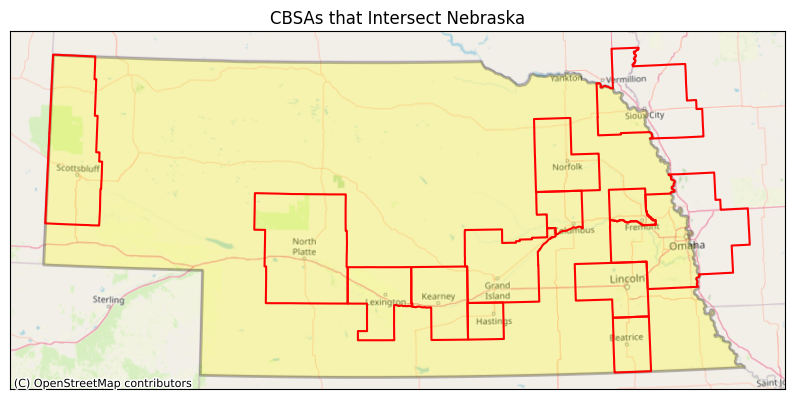

In [73]:
import censusdis.maps as cem

ax = cem.plot_map(
    gdf_ne_cbsa_intersects.boundary,
    color='red',
    with_background=True,
    figsize=(10, 5)
)

ax = cem.plot_map(
    gdf_ne,
    color='yellow',
    edgecolor='black',
    linewidth=2,
    alpha=0.25,
    ax=ax
)

ax.set_title("CBSAs that Intersect Nebraska");

The map makes it clear that what the CBSAs that intersect Nebraska look like. This is what the beta API
returns and aggregates over. The documentation should make it very clear that this is what the geoIds
that have the $ in the middle do, so as not to confuse users who know that in some cases data 
aggregated for intersecting parts of geometries is available, as we showed above.

The "All ZIP Code Tabulation Areas (ZCTAs) fully/partially within New Hampshire" example in the docs has
a similar character to this one, combining on and off-spine geographies. The other examples are all
on-spine so they don't have the same part vs. whole ambiguity.

### Variables

[link to docs](https://api.census.gov/docs/user-guide/concepts/variables.html)

I found this section of the documentation to be very sparse. In particular, what
I found missing here, or perhaps in a section of its own, is a description of the
construction of the data set and table ids like `"ACSDT5Y2015.B01001"` that I used
above. It should be of similar depth to the discussion of the construction of geoIds,
with a similar number of examples. I found that even as I poked around with the
sample queries, it took me a long time to understand enough about how these
ids work to be able to construct the ones I used in my queries above.

### Metadata

[link to docs](https://api.census.gov/docs/user-guide/concepts/metadata.html)

I do very much like that there is some metadata in this beta API. In the past,
I always have to separately get metadata from the simple dataset, group, and
variable APIs like 

- https://api.census.gov/data/2022/acs/acs5.json
- https://api.census.gov/data/2022/acs/acs5/groups.json
- https://api.census.gov/data/2022/acs/acs5/variables.json
- https://api.census.gov/data/2022/acs/acs5/groups/B01003.json,
- https://api.census.gov/data/2022/acs/acs5/variables/B01003_001E.json

I also think it would be super-nice to have one API that also included
the CB and TIGER maps. As you saw in the section above, `censusdis`
combines data and maps on the client side so users don't have to think
about an entirely different way to download shapefiles, manage them,
and merge them with data locally.

### Time

[link to docs](https://api.census.gov/docs/user-guide/concepts/time.html)

I like the idea of being able to query across multiple years. I did not try
this functionality out how to encode multiple years in table ids, or if that
is even an intended use case.

### Codesets

[link to docs](https://api.census.gov/docs/user-guide/concepts/codeset.html)

I would like to see better support for navigating the trees of codesets 
like the NAICS. I don't know if tools for doing so are including in the
beta API.

## Conclusions

Before I conclude, I would like to humbly offer an alternative vision of an easy to use
web API that does not have the issues raied above.

### An Alternative Approach

Briefly, one alternative I have considered, but not pursued only for lack of funding to
operate a server fleet on which to run it, would be to expose the `censusdis` API almost
directly to the web. Essentially the style of query you saw above, with keyword-based
geography and all the rest would be implemented by accepting the arguments to a call
to `ced.download` via JSON, parsing them, validating them, calling `ced.download` to
do the work of calling the existing Census APIs, then packing up all the results,
map geometry included, and returning it to the caller as JSON, GeoJSON, or a modern
format like [Arrow Flight](https://arrow.apache.org/cookbook/py/flight.html). This would 
not be technically difficult to build. It only lacks for operational funding.

A detailed discussion is beyond the scope of this document. However, from the perspective
of the average researcher looking for Census data via API, I think this would be a far more 
compelling design than the faceted beta API offers.

### Final Thoughts

I have done what I consider a thorough, but not exhaustive, review of the proposed beta API.
I approached this from the persectives of researchers and maintainers of client codebases
for the current version of the API. 

I did not find the coding by string construction to be a great option for most users. On the
other hand, I did like the move in the direction of including metadata and data in the same
API.

I think there are large corners of the beta API that I did not dig into. There are a handful
of examples of these provided, but there are not detailed descriptions of the underlying 
approach. I would be especially interested in sequences showing how data sets, tables, and
columns are discovered and how table ids are constructed.

I would be happy to follow up and review any new materials that address these issues.